# This notebook is used to generate the training data for the Gaussian Mixture Model (GMM)

# 1. Load data

In [1]:
# define the path of the data and project
proj_path = 'D:/VScode/MRes/Clustering_under_the_ice/'
data_path = 'D:/VScode/MRes/scienceweb.whoi.edu/itp/data/'

In [2]:
# read the cleaned xarray from local file
import xarray as xr
ds_cleaned_750=xr.open_dataset(f"{data_path}/ds_cleaned_750.nc")
# convert the profile data to string
ds_cleaned_750['profiler']=ds_cleaned_750['profiler'].astype(str)

In [3]:
# read the cleaned xarray from local file
import xarray as xr
ds_cleaned_250=xr.open_dataset(f"{data_path}/ds_cleaned_250.nc")
# convert the profile data to string
ds_cleaned_250['profiler']=ds_cleaned_250['profiler'].astype(str)
ds_cleaned_250=ds_cleaned_250.where(ds_cleaned_250['lat']>60,drop=True)

In [4]:
ds_cleaned_750

<xarray.Dataset>
Dimensions:           (nprof: 44692, pressure: 148)
Coordinates:
    profiler          (nprof) <U13 'itp100grd0001' ... 'itp9grd1097'
    date              (nprof) datetime64[ns] ...
    lon               (nprof) float64 ...
    lat               (nprof) float64 ...
  * pressure          (pressure) float64 -10.0 -15.0 -20.0 ... -740.0 -745.0
Dimensions without coordinates: nprof
Data variables:
    temperature       (nprof, pressure) float64 ...
    salinity          (nprof, pressure) float64 ...
    dissolved_oxygen  (nprof, pressure) float64 ...

# 2. Define functions that prepare the training data

In [4]:
# the pipeline to prepare the training data
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import pandas as pd
import numpy as np
import plotly.graph_objs as go

def prepare_training_data(
    lat_step: float,
    lon_step: float,
    quantile4T: float,
    ds_cleaned: xr.Dataset,
    ratio_monthly_sampled: float = 1
) -> xr.Dataset:
    """
    Prepare the training data by spatially and temporally sample the cleaned data.

    Args:
        lat_step (float): The latitude step size.
        lon_step (float): The longitude step size.
        quantile4T (float): The quantile value for threshold calculation.
        ds_cleaned (xr.Dataset): The cleaned dataset.
        ratio_monthly_sampled (float, optional): The ratio for monthly sampling. Defaults to 1.

    Returns:
        xr.Dataset: The prepared training data.
    """
    threshold = int(cal_threshold(ds_cleaned, lat_step, lon_step, quantile=quantile4T))
    ds_cleaned_spatially_sampled = drop_profiles(ds_cleaned, lat_step, lon_step, threshold)
    ds_cleaned_monthly_sampled = ramdon_sample_by_month(ds_cleaned_spatially_sampled, ratio_monthly_sampled, random_seed=0)
    ds_cleaned_monthly_sampled['lat_step'] = lat_step
    ds_cleaned_monthly_sampled['lon_step'] = lon_step
    ds_cleaned_monthly_sampled['quantile4T'] = quantile4T
    print(f'threshold={threshold}, training dataset size={len(ds_cleaned_monthly_sampled.nprof)}')
    return ds_cleaned_monthly_sampled


#############################################################################################################

def cal_threshold(
    ds: xr.Dataset,
    lat_step: float,
    lon_step: float,
    quantile: float
) -> int:
    """
    Calculate the threshold based on the difference between adjacent elements in the sorted latitude-longitude bins.

    Args:
        ds (xr.Dataset): The dataset.
        lat_step (float): The latitude step size for binning.
        lon_step (float): The longitude step size for binning.
        quantile (float): The quantile value for threshold calculation.

    Returns:
        int: The calculated threshold.
    """
    df_latlon = ds[['lat', 'lon']].to_dataframe()

    lon_bins = pd.cut(df_latlon['lon'], bins=np.arange(-180, 185, lon_step))
    lat_bins = pd.cut(df_latlon['lat'], bins=np.arange(-90, 95, lat_step))

    latlon_groups = df_latlon.groupby([lon_bins, lat_bins])

    g_len = []
    for group_key in latlon_groups.groups:
        try:
            group = latlon_groups.get_group(group_key)
            # print(f"Group {group_key}: {len(group)} rows")
            g_len.append(len(group))
        except KeyError:
            # Handle the KeyError gracefully
            print(f"No data points for group {group_key}")

    g_len_sorted = sorted(g_len)
    transition_point = None

    g_len_diff = np.diff(g_len_sorted)

    threshold = np.quantile(g_len_diff, quantile)  # set a threshold for the difference between adjacent elements

    for i in range(1, len(g_len_sorted)):
        if g_len_sorted[i] - g_len_sorted[i-1] > threshold:
            transition_point = i - 1
            break

    return g_len_sorted[transition_point]


####################################################################################
import numpy as np
import xarray as xr
import pandas as pd

def drop_profiles(
    ds: xr.Dataset,
    lat_step: float,
    lon_step: float,
    threshold: int
) -> xr.Dataset:
    """
    Drop the profiles in the bins with sample size larger than the threshold.

    Args:
        ds (xr.Dataset): The dataset.
        lat_step (float): The latitude step size for binning.
        lon_step (float): The longitude step size for binning.
        threshold (int): The threshold for dropping profiles.

    Returns:
        xr.Dataset: The dataset with profiles dropped.
    """
    df_latlon = ds[['lat', 'lon']].to_dataframe()

    lon_bins = pd.cut(df_latlon['lon'], bins=np.arange(-180, 185, lon_step))
    lat_bins = pd.cut(df_latlon['lat'], bins=np.arange(-90, 95, lat_step))

    latlon_groups = df_latlon.groupby([lon_bins, lat_bins])

    latlon_groups_list = []

    for group_key in latlon_groups.groups:
        try:
            group = latlon_groups.get_group(group_key)
            if len(group) > threshold:
                group_drop = group.sample(n=len(group)-threshold, random_state=0)
                latlon_groups_list.append(group_drop)
        except KeyError:
            print(f"No data points for group {group_key}")

    ds_spatially_sampled = ds.copy()

    nprof_dropped = []

    for group in latlon_groups_list:
        temp_index = group.index.values
        nprof_dropped.append(temp_index.tolist())

    nprof_dropped = [item for sublist in nprof_dropped for item in sublist]

    ds_spatially_sampled = ds_spatially_sampled.drop_sel(nprof=nprof_dropped)

    return ds_spatially_sampled


########################################################################################################################


def ramdon_sample_by_month(
    ds: xr.Dataset,
    ratio: float,
    random_seed: int = 0
) -> xr.Dataset:
    """
    Sample profiles by month based on a given ratio.

    Args:
        ds (xr.Dataset): The dataset.
        ratio (float): The ratio of profiles to sample (between 0 and 1).
        random_seed (int, optional): The random seed for reproducibility. Defaults to 0.

    Returns:
        xr.Dataset: The dataset with sampled profiles.
    """
    if ratio < 0 or ratio > 1:
        raise ValueError("Ratio must be between 0 and 1.")

    if 'date' not in ds:
        raise ValueError("Input dataset must have a 'date' variable.")

    if 'nprof' not in ds.dims:
        raise ValueError("Input dataset must have a 'nprof' dimension.")

    ds_monthly = ds.groupby('date.month')
    months_with_data = [month for month in ds_monthly.groups.keys() if len(ds_monthly[month]) > 0]

    if not months_with_data:
        raise ValueError("Input dataset does not contain any data.")

    smallest_month_size = np.min([ds_monthly[month].nprof.size for month in months_with_data])
    selected_size_monthly = ds.nprof.size * ratio / 12

    if smallest_month_size < selected_size_monthly:
        selected_size_monthly = smallest_month_size
        print(f"Ratio is too large, selected_size_monthly is reset to the smallest_month_size: {smallest_month_size}")

    ds_selected = xr.concat([ds_monthly[month].isel(nprof=np.random.default_rng(random_seed).choice(ds_monthly[month].nprof.size, int(selected_size_monthly), replace=False)) for month in months_with_data], dim='nprof')

    ds_selected['nprof'] = np.arange(ds_selected.sizes['nprof'])

    return ds_selected


#############################################################################################################

def profileNo_vs_latlon_bins(
    ds: xr.Dataset,
    lat_step: float,
    lon_step: float,
    show_threshold: bool = False,
    threshold_quantile: float = 0.95
) -> None:
    """
    Plot the number of profiles in each latitude-longitude bin.

    Args:
        ds (xr.Dataset): The dataset to plot.
        lat_step (float): The latitude step size for binning.
        lon_step (float): The longitude step size for binning.
        show_threshold (bool, optional): Whether to show the threshold marker. Defaults to False.
        threshold_quantile (float, optional): The quantile value for threshold calculation. Defaults to 0.95.

    Returns:
        None
    """
    df_latlon = ds[['lat', 'lon']].to_dataframe()

    lon_bins = pd.cut(df_latlon['lon'], bins=np.arange(-180, 185, lon_step))
    lat_bins = pd.cut(df_latlon['lat'], bins=np.arange(-90, 95, lat_step))

    latlon_groups = df_latlon.groupby([lon_bins, lat_bins])

    g_len = []
    for group_key in latlon_groups.groups:
        try:
            group = latlon_groups.get_group(group_key)
            # print(f"Group {group_key}: {len(group)} rows")
            g_len.append(len(group))
        except KeyError:
            # Handle the KeyError gracefully
            print(f"No data points for group {group_key}")

    g_len_sorted = sorted(g_len)
    transition_point = None

    g_len_diff = np.diff(g_len_sorted)

    threshold = np.quantile(g_len_diff, threshold_quantile)  # set a threshold for the difference between adjacent elements

    for i in range(1, len(g_len_sorted)):
        if g_len_sorted[i] - g_len_sorted[i-1] > threshold:
            transition_point = i - 1
            break

    trace = go.Scatter(
        x=list(range(len(g_len_sorted))),
        y=g_len_sorted
    )

    if show_threshold:
        if transition_point is not None:
            red_dot = go.Scatter(
                x=[transition_point],
                y=[g_len_sorted[transition_point]],
                mode='markers',
                marker=dict(color='red', size=10)
            )
            fig_data = [trace, red_dot]
        else:
            fig_data = [trace]
    else:
        fig_data = [trace]

    layout = go.Layout(
        xaxis=dict(title='Bin No.'),
        yaxis=dict(title='Number of profiles')
    )

    fig = go.Figure(data=fig_data, layout=layout)
    fig.show()



# 3. Step by step break down
## The uneven spatial distribution of the data 
As showed in the figures below, the temporal and spatial distribution of the data is not even. Thus, a sampling in both spatial and temporal domain is needed. Here, the temporal sampling can be done by simply sample same amount of data from each month and we will perform this after the spatial sampling

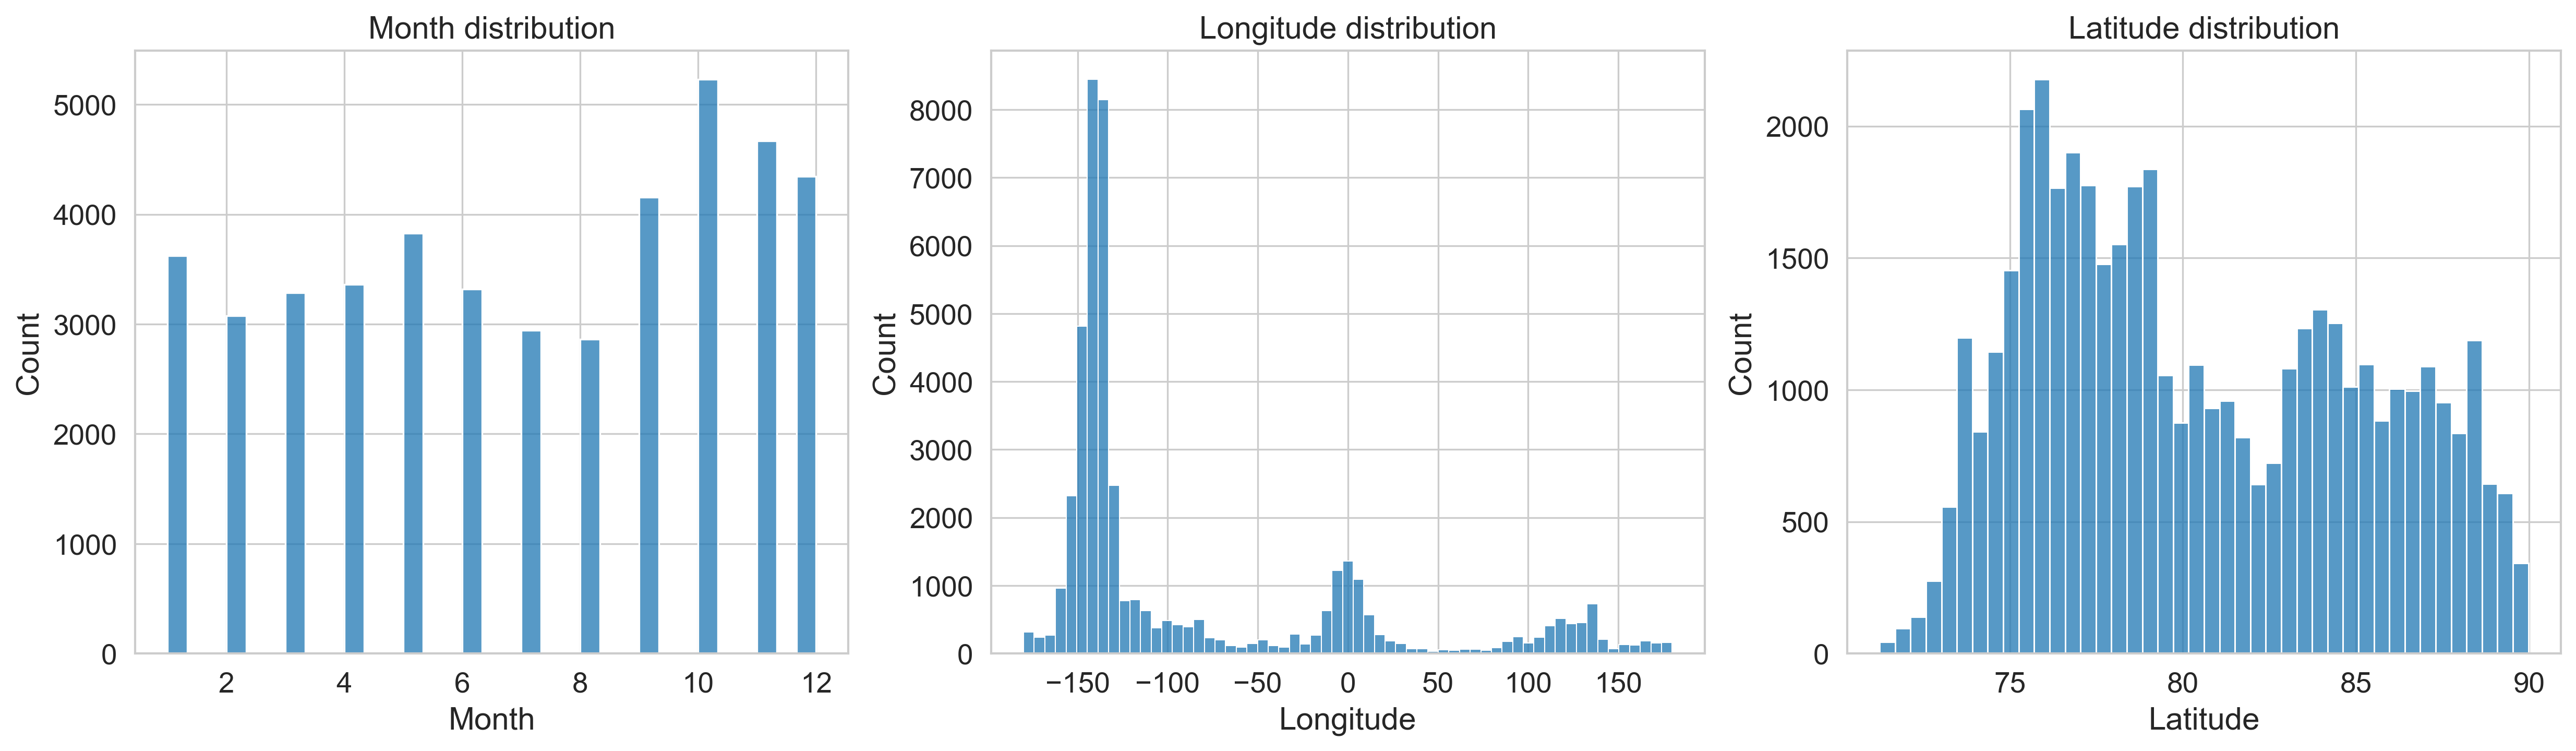

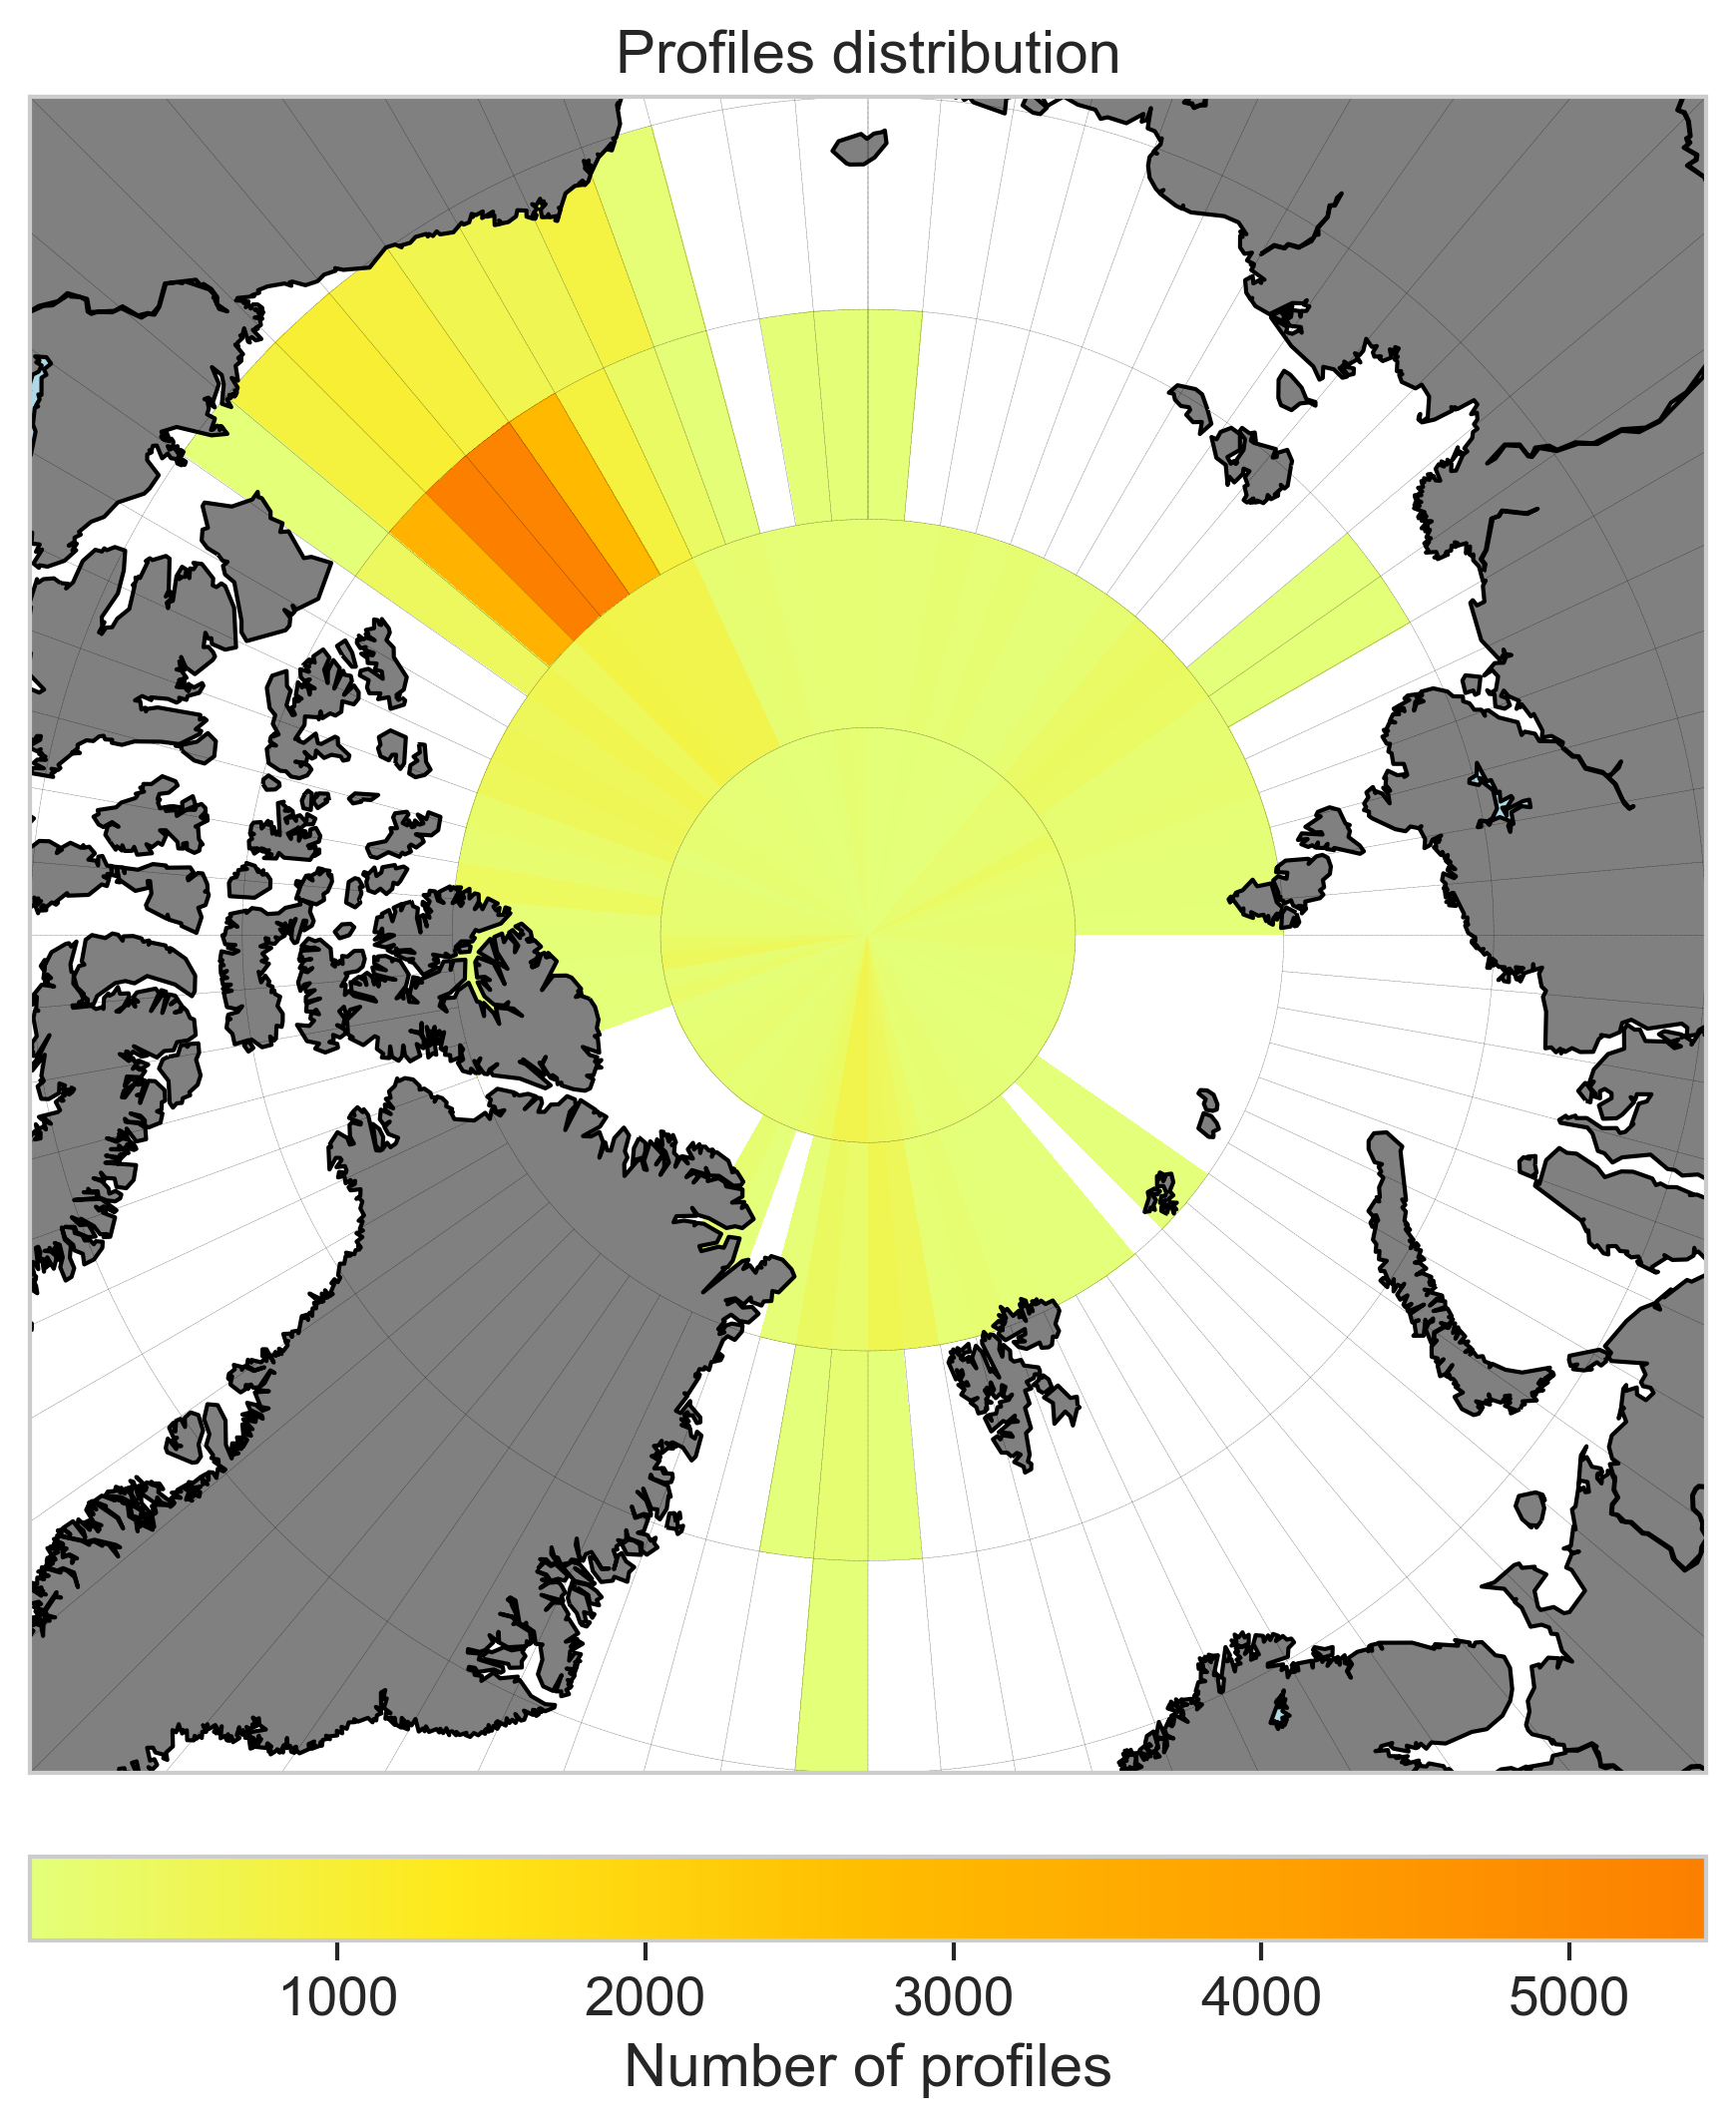

bin max=5444.0


In [6]:
from toolbox import plot_basic_statistics as pbs
pbs.plot_month_latlon_dis(ds_cleaned_750)
pbs.plot_heatmap(ds_cleaned_750)

## The spatial sampling: devide data into bins and the Threhold of the number of profile in bins 
For spatial sampling, one way to remove the bias in the data is to divide the data into latitude-longitude bins (defined by the lat_step and lon_step) and then reduce the number of samples took from the bins that got exceptionally high profile number. When set lat_step and lon_step to 10 and 20 degree respectively, and calculate the number of profiles in each bin and then sorted it, The following figure is generated. The red dot mark the place where the number of profile is exceptionally high, we called this value Threshold (T). Here we used the 95% quantile of the profile number in bins as the T value.  

In [5]:
profileNo_vs_latlon_bins(ds_cleaned_750, 5, 60,show_threshold=True)

## How the Threshold and number of the sampled data change with lat_step and lon_step
It is obvious that the T value and the number of profile after this spatial sampling changes when different lat_step and lon_step is used. The following figure showed the T and the number of profile of the sampled data when using different lat_step and lon_step. 

In [6]:
# find the bining scheme that maximizes the number of profiles

def latlon_bining_ana(ds):
    lat_bins=[2,5,10]
    lon_bins=[10,20,30,40,50,60,70,80]
    ds_len=[]
    threshold=[]
    for i in lat_bins:
        for j in lon_bins:
            # T=cal_threshold(ds, i, j, quantile=0.95)
            T=int(cal_threshold(ds, i, j, quantile=0.95))
            ds_spatially_sampled = drop_profiles(ds, i, j, T)
            ds_monthly_sampled = ramdon_sample_by_month(ds_spatially_sampled, 1, random_seed=0)
            threshold.append(T)
            ds_len.append(ds_monthly_sampled.nprof.size)

    threshold=np.array(threshold)
    threshold=threshold.reshape(len(lat_bins),len(lon_bins))
    threshold=threshold.T
    threshold=pd.DataFrame(threshold,index=lon_bins,columns=lat_bins)

    # plot the ds_len changes with i and j as line plot
    ds_len=np.array(ds_len)
    ds_len=ds_len.reshape(len(lat_bins),len(lon_bins))
    ds_len=ds_len.T
    ds_len=pd.DataFrame(ds_len,index=lon_bins,columns=lat_bins)

    # plot the heatmap of the threshold and number of profiles
    fig, axs = plt.subplots(1, 2, figsize=(14, 6),dpi=300)
    sns.set_theme(style="whitegrid")

    # plot the heatmap of the threshold
    sns.heatmap(threshold, annot=True, linewidths=.5, cmap='YlGnBu', ax=axs[0])
    axs[0].set_title('Threshold')
    axs[0].set_xlabel('Latitude bin')
    axs[0].set_ylabel('Longitude bin')

    # plot the heatmap of the number of profiles
    sns.heatmap(ds_len, annot=True, linewidths=.5, cmap='YlGnBu', ax=axs[1])
    axs[1].set_title('Number of profiles')
    axs[1].set_xlabel('Latitude bin')
    axs[1].set_ylabel('Longitude bin')
    
    plt.show()



Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 2616
Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 2659
Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 2420
Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 2746
No data points for group (nan, Interval(78, 80, closed='right'))
No data points for group (nan, Interval(80, 82, closed='right'))
No data points for group (nan, Interval(82, 84, closed='right'))
No data points for group (nan, Interval(84, 86, closed='right'))
No data points for group (nan, Interval(86, 88, closed='right'))
No data points for group (nan, Interval(88, 90, closed='right'))
No data points for group (nan, Interval(78, 80, closed='right'))
No data points for group (nan, Interval(80, 82, closed='right'))
No data points for group (nan, Interval(82, 84, closed='right'))
No data points for group (nan, Interval(84, 86, closed='right'))
No data points

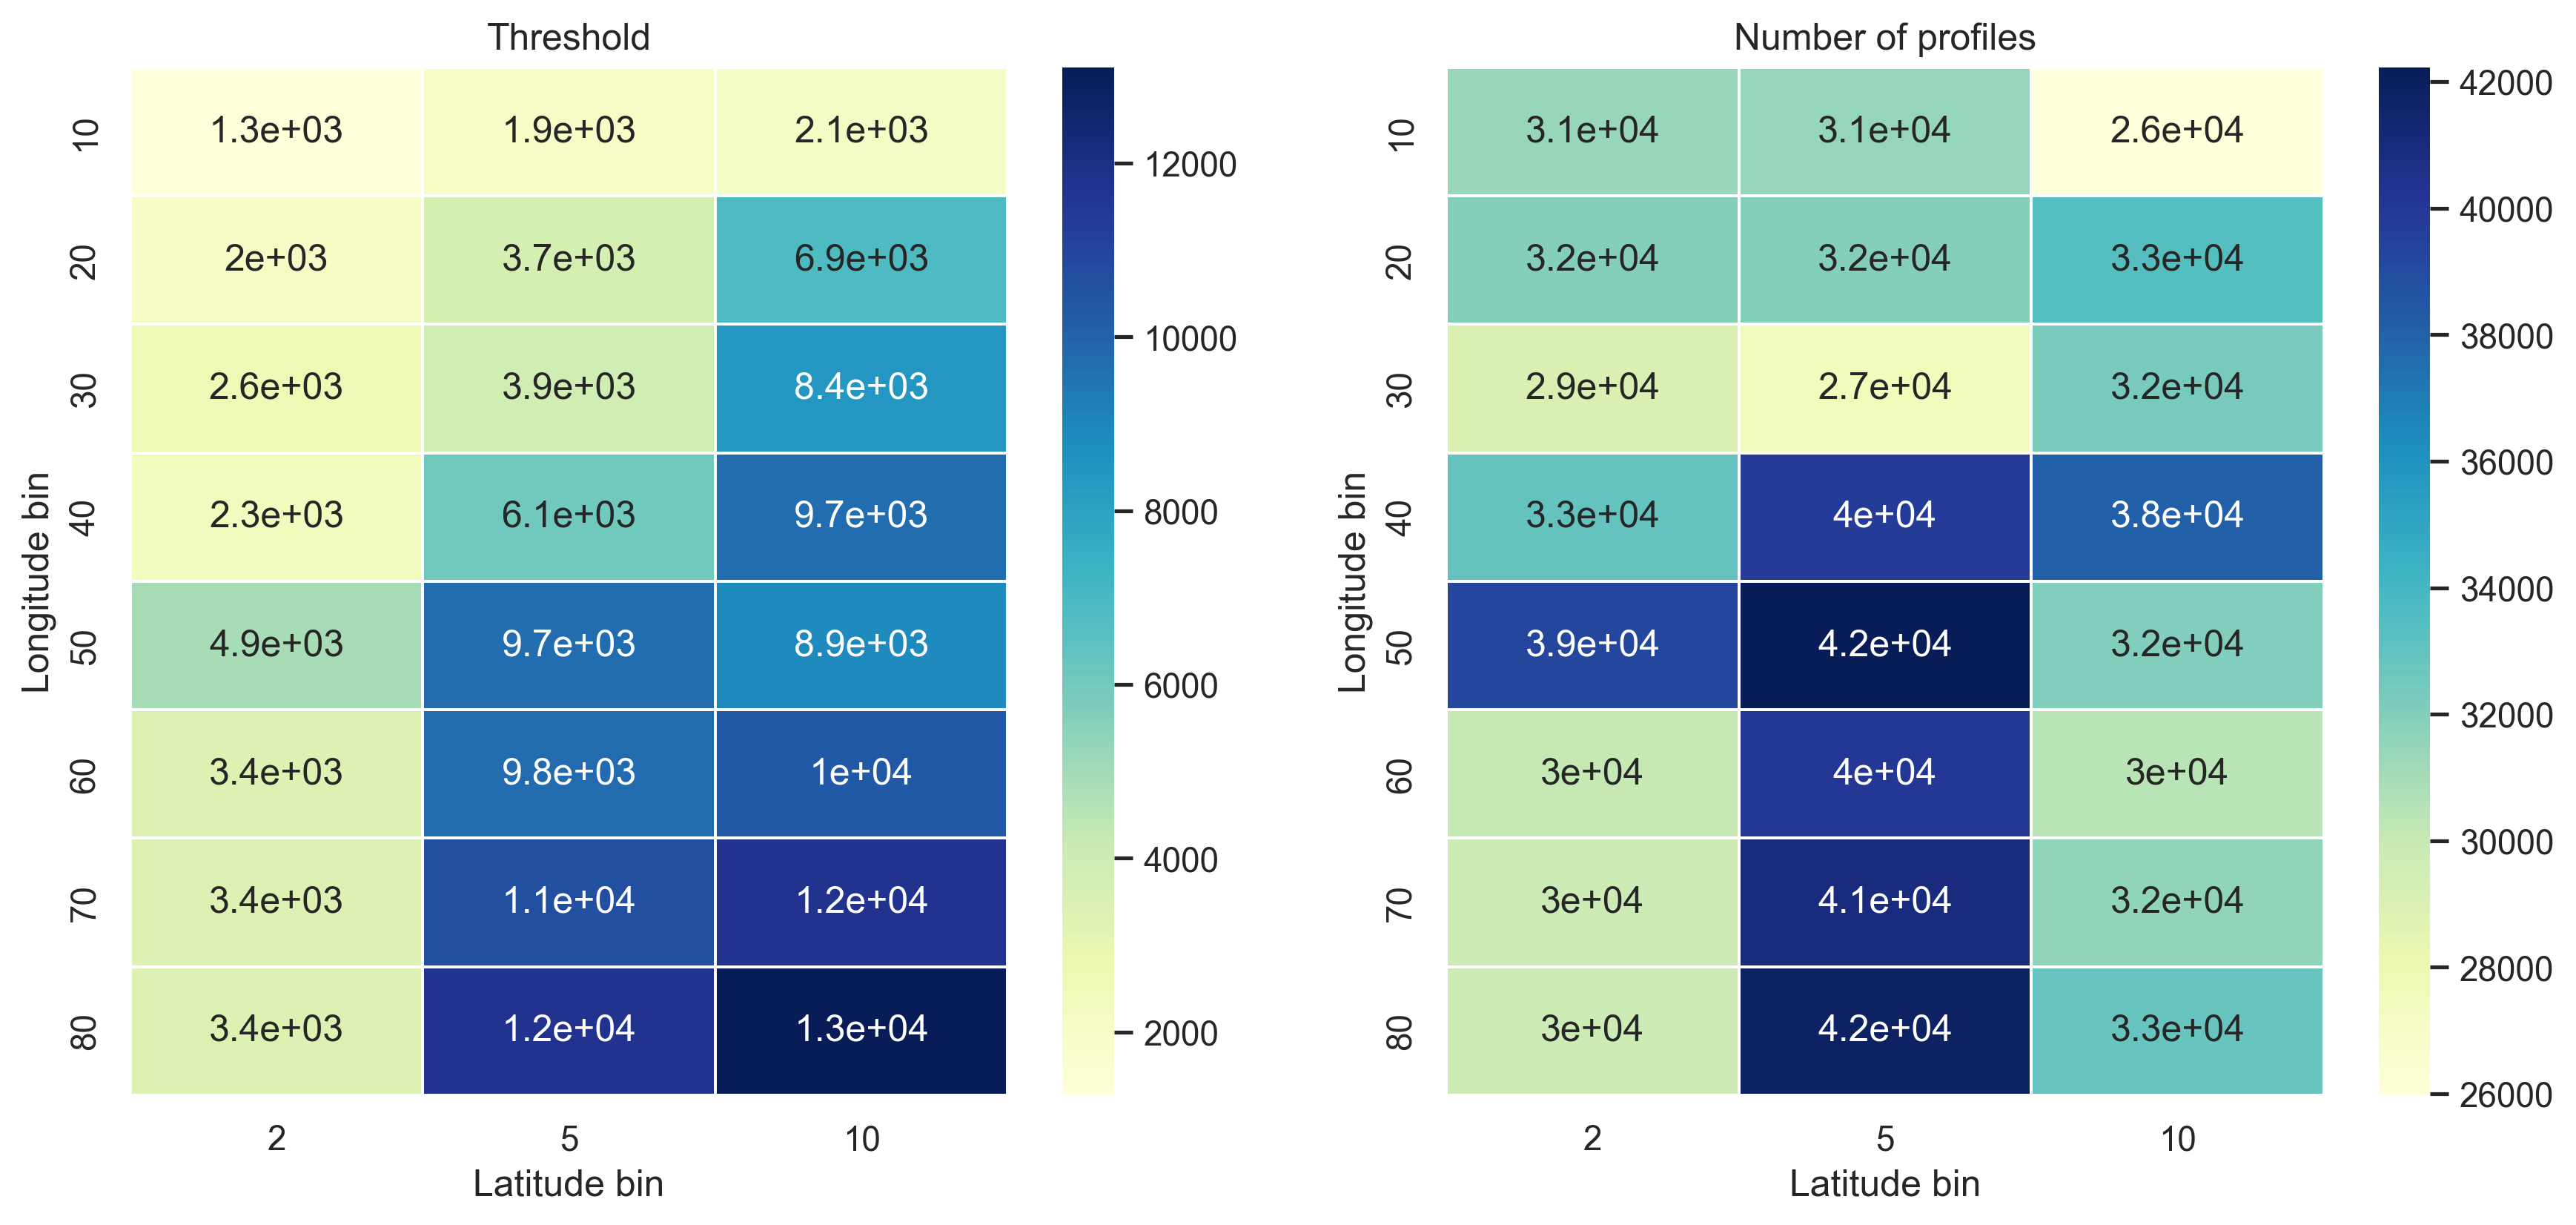

In [93]:
latlon_bining_ana(ds_cleaned_250)

## Measurement of what is good training data: spatial coverage and spatial variance
The T and number of profiles after sampling do not derictly help the selection of proper lat_step and lon_step. So, we consider the spatial coverage and spatial variance. Here the spatial coverage is how many area the sampled data covers, while the spatial variance is to devide the sampled data to 1 by 1 latitude longitude bins and the variance of the number of profile in bins. A good training data would be the one with high spatial coverage while low spatial variance

In [7]:
# '''Define the function that compare the spatial distribution of sampled data with the original data in a same plot'''
# def plot_latlon_coverage(ds,ds_sampled):
#     sns.set_style("whitegrid")
#     sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
#     fig, ax = plt.subplots(1,1,figsize=(10,10),dpi=300)
#     sns.scatterplot(data=ds,x='lon',y='lat',s=5,label='Original data')
#     sns.scatterplot(data=ds_sampled,x='lon',y='lat',s=5,label='Sampled data')
#     # set the x and y label
#     ax.set_xlabel('Longitude')
#     ax.set_ylabel('Latitude')
#     # set the title
#     # ax.set_title('Profiles distribution')
#     plt.show()

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

def plot_latlon_coverage(ds, ds_sampled):
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
    
    # Set figure size and dpi
    plt.figure(figsize=(10,10), dpi=300)
    
    # Create a subplot with an Arctic centered map projection
    ax = plt.subplot(projection=ccrs.NorthPolarStereo())
    
    # Limit the map to 60 degrees latitude and above.
    ax.set_extent([-180, 180, 70, 90], ccrs.PlateCarree())

    # Add a grid and coastlines for reference
    ax.gridlines()
    ax.coastlines()

    # Create scatter plots
    ax.scatter(ds['lon'], ds['lat'], s=5, 
               transform=ccrs.PlateCarree(), 
               label='Original data')
    
    ax.scatter(ds_sampled['lon'], ds_sampled['lat'], s=5, 
               transform=ccrs.PlateCarree(), 
               label='Reduced data')

    # Add a legend
    plt.legend()
    
    plt.show()


In [6]:
# define the path of the data and project
training_data_path = 'D:/VScode/MRes/Clustering_under_the_ice/training_data/'
# load the training data
import xarray as xr

ds_train_750_latlonT_5_60_95= xr.open_dataset(training_data_path + 'ds_train_750_latlonT_5_60_95.nc')
ds_train_750_latlonT_5_60_95['profiler']=ds_train_750_latlonT_5_60_95['profiler'].astype(str)

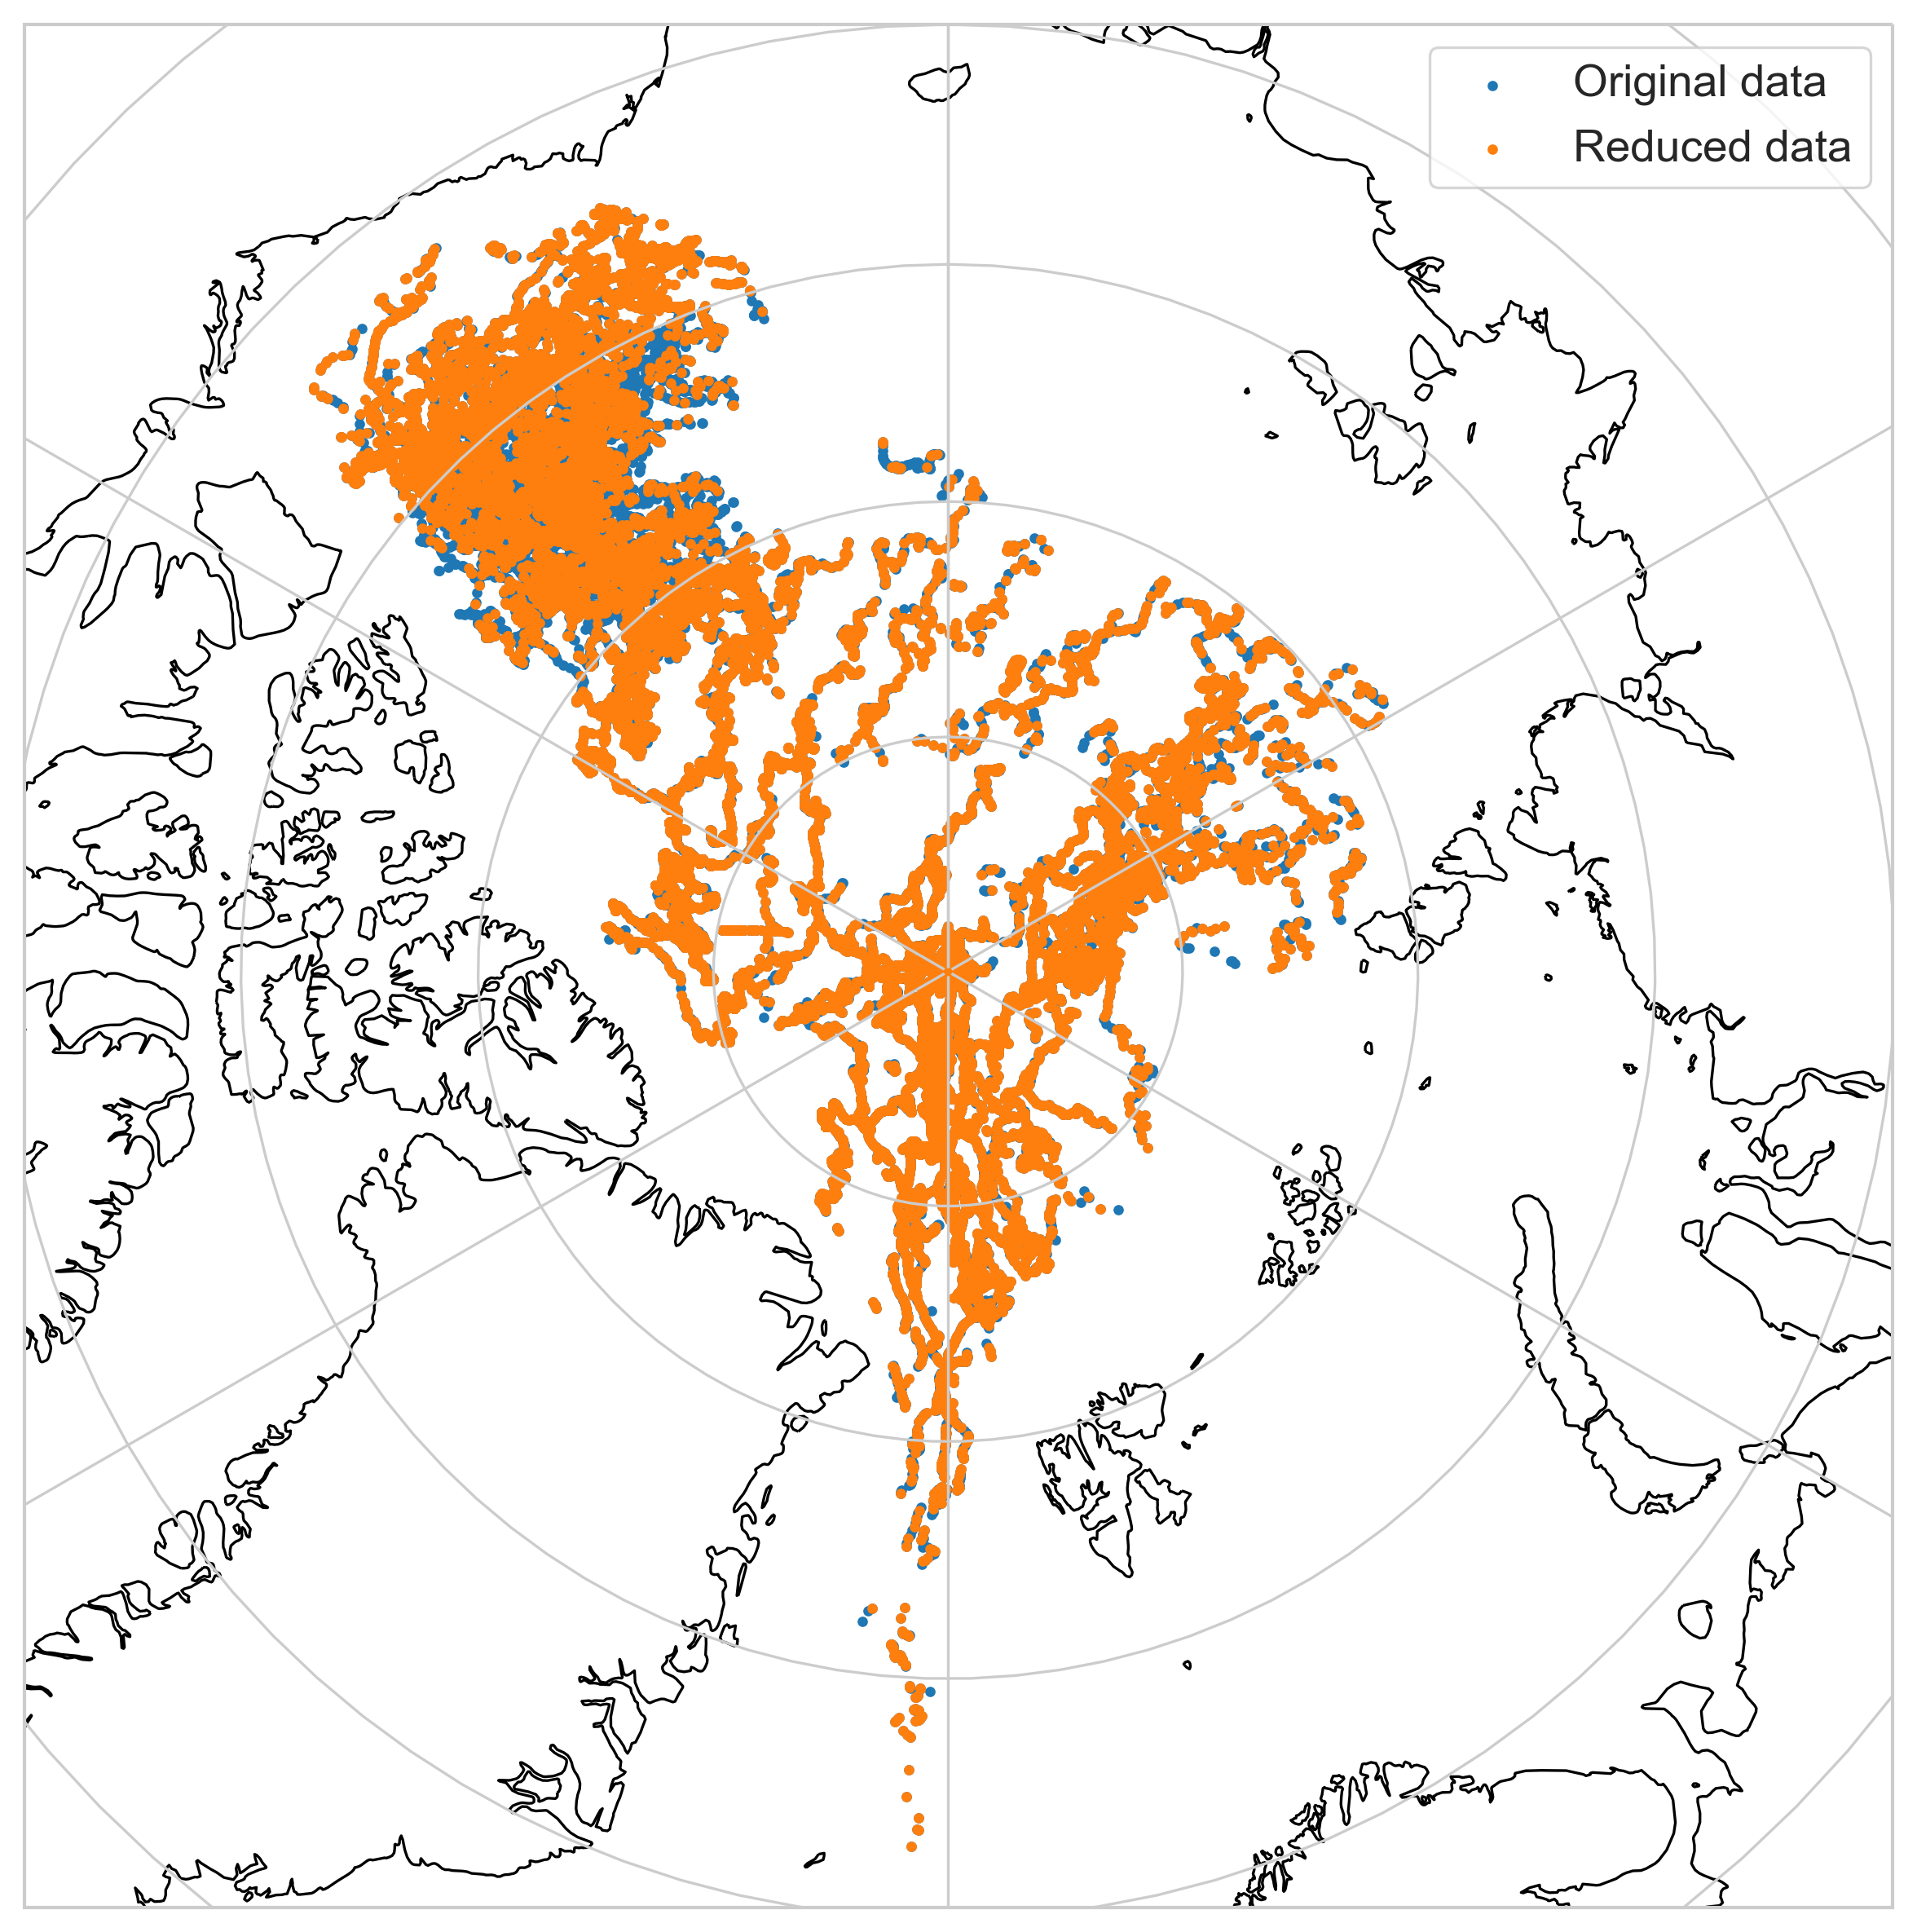

In [14]:
plot_latlon_coverage(ds_cleaned_750,ds_train_750_latlonT_5_60_95)

The following code is an example to print the spatial coverage in forms of percentage

In [10]:
ds_train_750_latlonT_2_60_95=prepare_training_data(2,60,0.95,ds_cleaned_750)

Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 2148
threshold=3170, training dataset size=25776


In [20]:
# measure the spatial coverage of the sampled data compared with the original data
import numpy as np

def compare_spatial_coverage(ds,ds_sampled):
    # get the unique lat-lon pints of the original data
    ds_unique = np.unique((ds.lat.values, ds.lon.values), axis=1)
    # print(ds_unique.shape)
    # get the unique lat-lon pints of the sampled data
    ds_sampled_unique=np.unique((ds_sampled.lat.values, ds_sampled.lon.values), axis=1)
    # print(ds_sampled_unique.shape)
    coverage=ds_sampled_unique.shape[1]/ds_unique.shape[1]
    return coverage


In [63]:
compare_spatial_coverage(ds_cleaned_750,ds_train_750_latlonT_2_60_95)

0.5854967660797701

## How the spatial coverage and spatial variance change with lat_step and lon_step
The following code run through different lat_step and lon_step combination and show the spatial coverage and spatial variance in the form of heatmap

In [18]:
def cal_spatial_density(ds):
    # Convert the 'lat' and 'lon' variables into a pandas dataframe
    df_latlon = ds[['lat', 'lon']].to_dataframe()
    lat_step=1
    lon_step=1

    lon_bins = pd.cut(df_latlon['lon'], bins=np.arange(-180,185, lon_step))
    lat_bins = pd.cut(df_latlon['lat'], bins=np.arange(-90,95, lat_step))

    latlon_groups = df_latlon.groupby([lon_bins, lat_bins])

    g_len=[]
    for group_key in latlon_groups.groups:
        try:
            group = latlon_groups.get_group(group_key)
            #print(f"Group {group_key}: {len(group)} rows")
            g_len.append(len(group))
        except KeyError:
            # Handle the KeyError gracefully
            print(f"No data points for group {group_key}")

    var=np.var(g_len)

    return var



def coverage_ana(ds):
    lat_bins=[2,5,10]
    lon_bins=[10,20,30,40,50,60,70,80]
    coverage_list=[]
    var_list=[]
    for i in lat_bins:
        for j in lon_bins:
            T=int(cal_threshold(ds, i, j, quantile=0.95))
            ds_spatially_sampled = drop_profiles(ds, i, j, T)
            ds_monthly_sampled = ramdon_sample_by_month(ds_spatially_sampled, 1, random_seed=0)
            coverage=compare_spatial_coverage(ds,ds_monthly_sampled)
            coverage_list.append(coverage)
            var=cal_spatial_density(ds_monthly_sampled)
            var_list.append(var)
    
    # plot the heatmap of the coverage
    coverage_list=np.array(coverage_list)
    coverage_list=coverage_list.reshape(len(lat_bins),len(lon_bins))
    coverage_list=coverage_list.T
    coverage_list=pd.DataFrame(coverage_list,index=lon_bins,columns=lat_bins)

    # plot the heatmap of the var
    var_list=np.array(var_list)
    var_list=var_list.reshape(len(lat_bins),len(lon_bins))
    var_list=var_list.T
    var_list=pd.DataFrame(var_list,index=lon_bins,columns=lat_bins)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6),dpi=300)
    sns.set_theme(style="whitegrid")

    # plot the heatmap of the coverage
    sns.heatmap(coverage_list*100, annot=True, linewidths=.5, cmap='YlGnBu', ax=axs[0])
    axs[0].set_title('The spatial coverage of sampled data (%)')
    axs[0].set_xlabel('Latitude bin')
    axs[0].set_ylabel('Longitude bin')

    # plot the heatmap of the var
    sns.heatmap(var_list, annot=True, linewidths=.5, cmap='Wistia', ax=axs[1])
    axs[1].set_title('Variance of spatial density (lower is better)')
    axs[1].set_xlabel('Latitude bin')
    axs[1].set_ylabel('Longitude bin')

    plt.show()
    

Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 1337
Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 1567
Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 1583
Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 2233
No data points for group (nan, Interval(78, 80, closed='right'))
No data points for group (nan, Interval(80, 82, closed='right'))
No data points for group (nan, Interval(82, 84, closed='right'))
No data points for group (nan, Interval(84, 86, closed='right'))
No data points for group (nan, Interval(86, 88, closed='right'))
No data points for group (nan, Interval(88, 90, closed='right'))
No data points for group (nan, Interval(78, 80, closed='right'))
No data points for group (nan, Interval(80, 82, closed='right'))
No data points for group (nan, Interval(82, 84, closed='right'))
No data points for group (nan, Interval(84, 86, closed='right'))
No data points

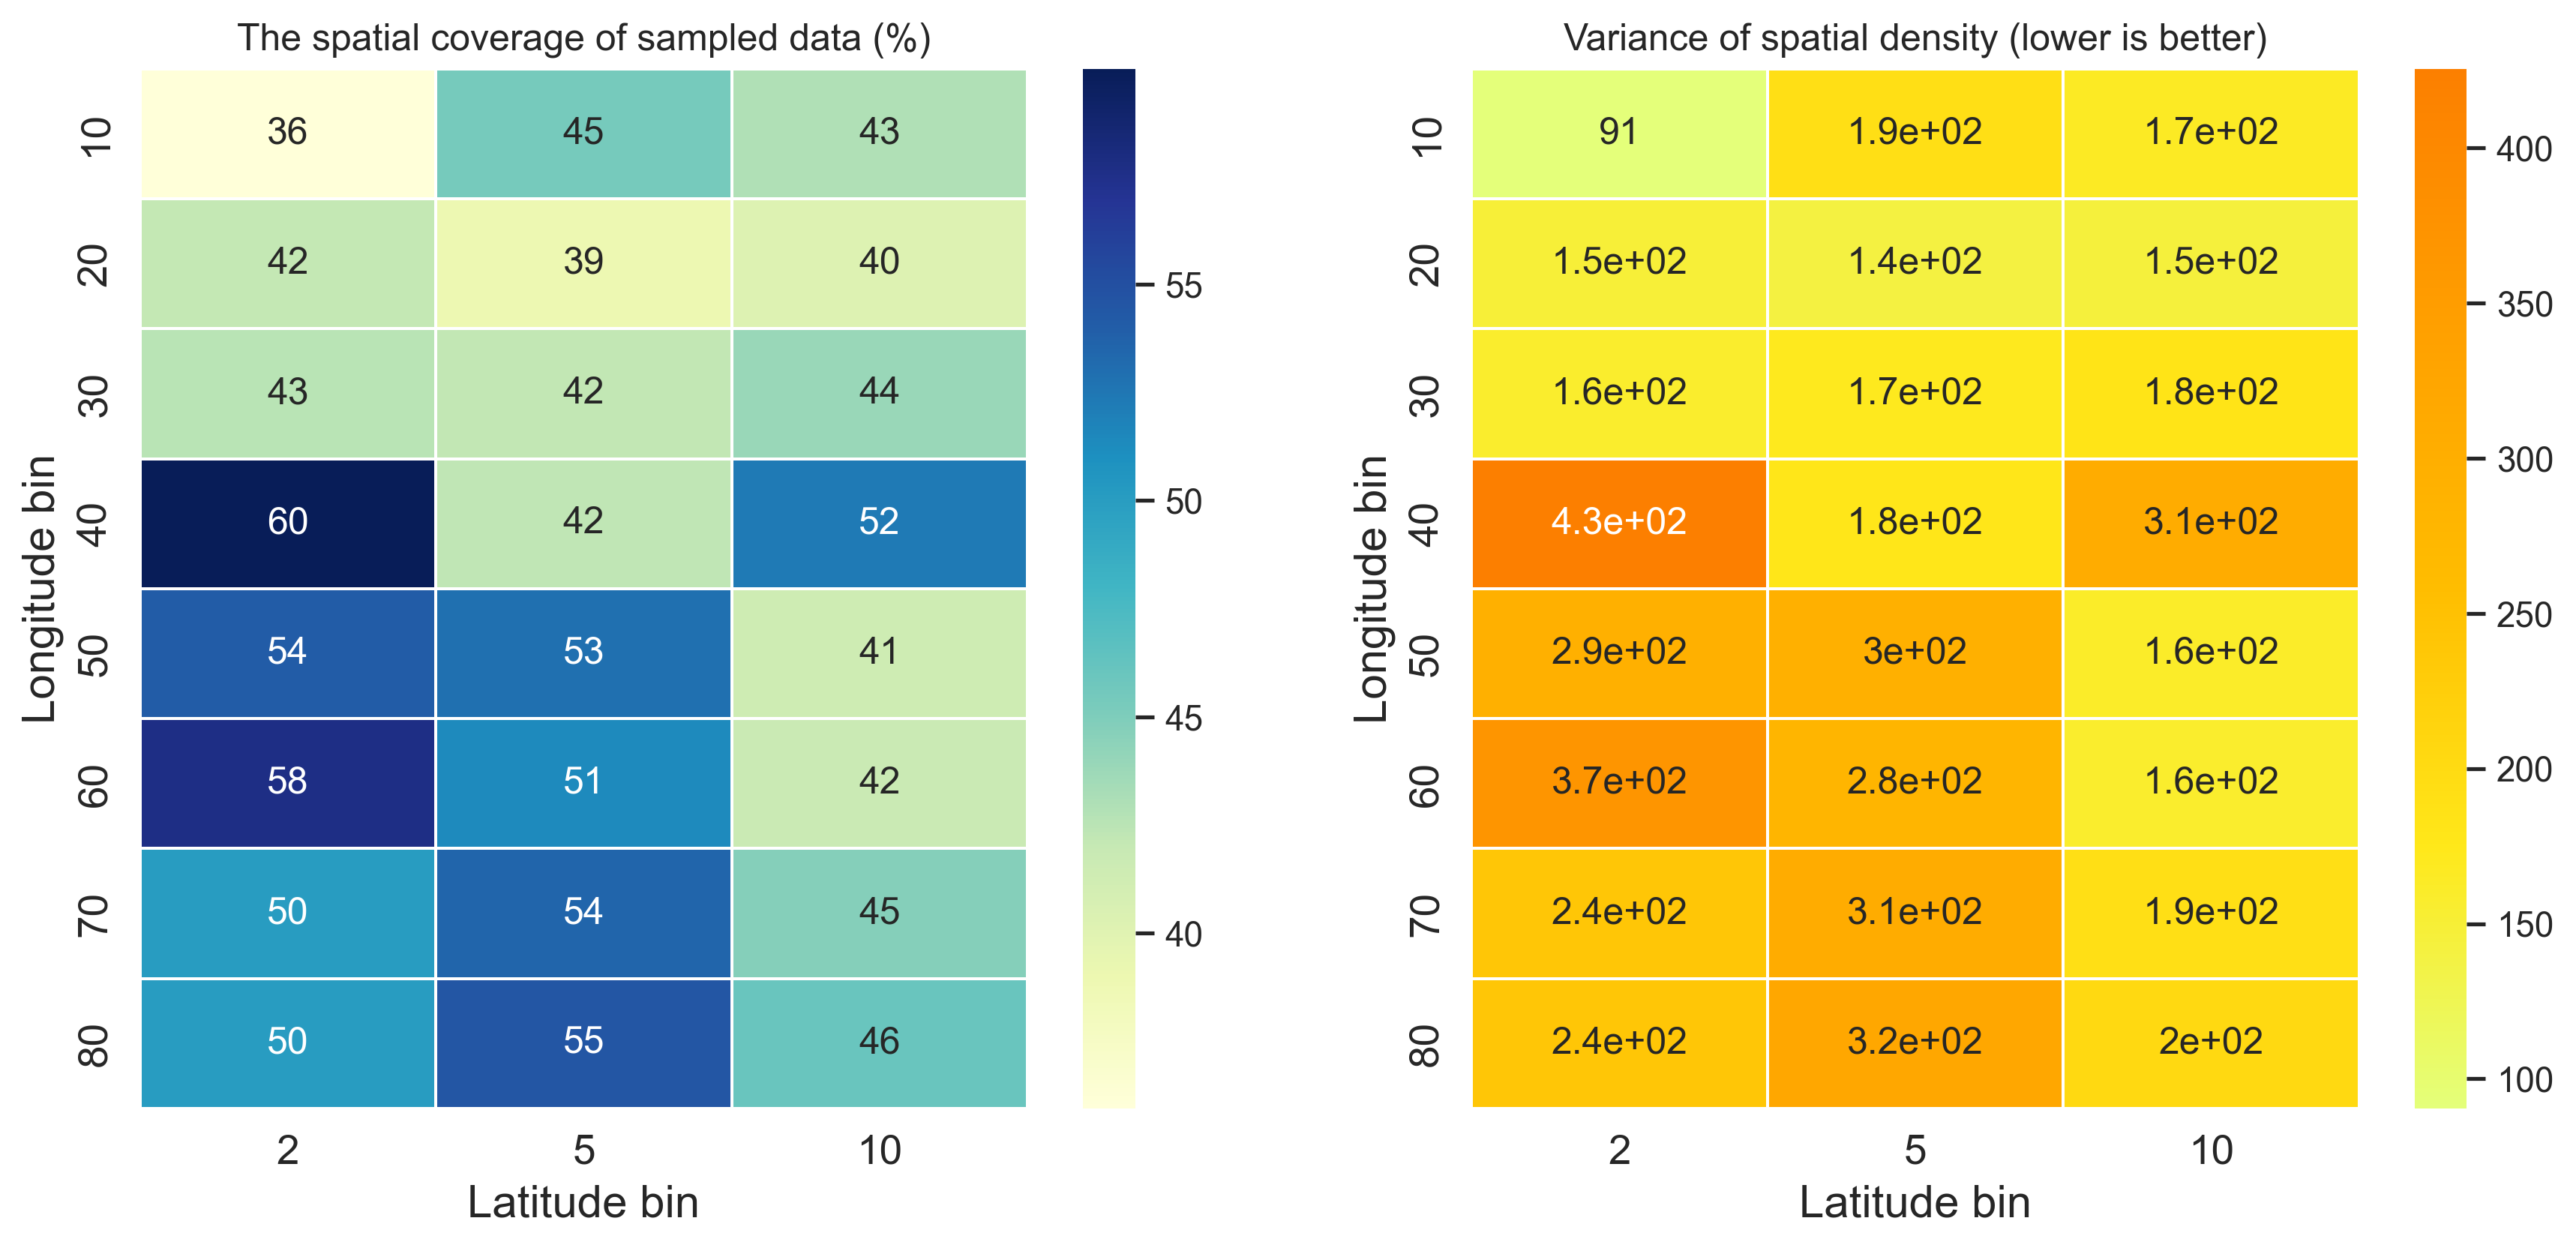

In [21]:
coverage_ana(ds_cleaned_750)

Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 2616
Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 2659
Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 2420
Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 2746
No data points for group (nan, Interval(78, 80, closed='right'))
No data points for group (nan, Interval(80, 82, closed='right'))
No data points for group (nan, Interval(82, 84, closed='right'))
No data points for group (nan, Interval(84, 86, closed='right'))
No data points for group (nan, Interval(86, 88, closed='right'))
No data points for group (nan, Interval(88, 90, closed='right'))
No data points for group (nan, Interval(78, 80, closed='right'))
No data points for group (nan, Interval(80, 82, closed='right'))
No data points for group (nan, Interval(82, 84, closed='right'))
No data points for group (nan, Interval(84, 86, closed='right'))
No data points

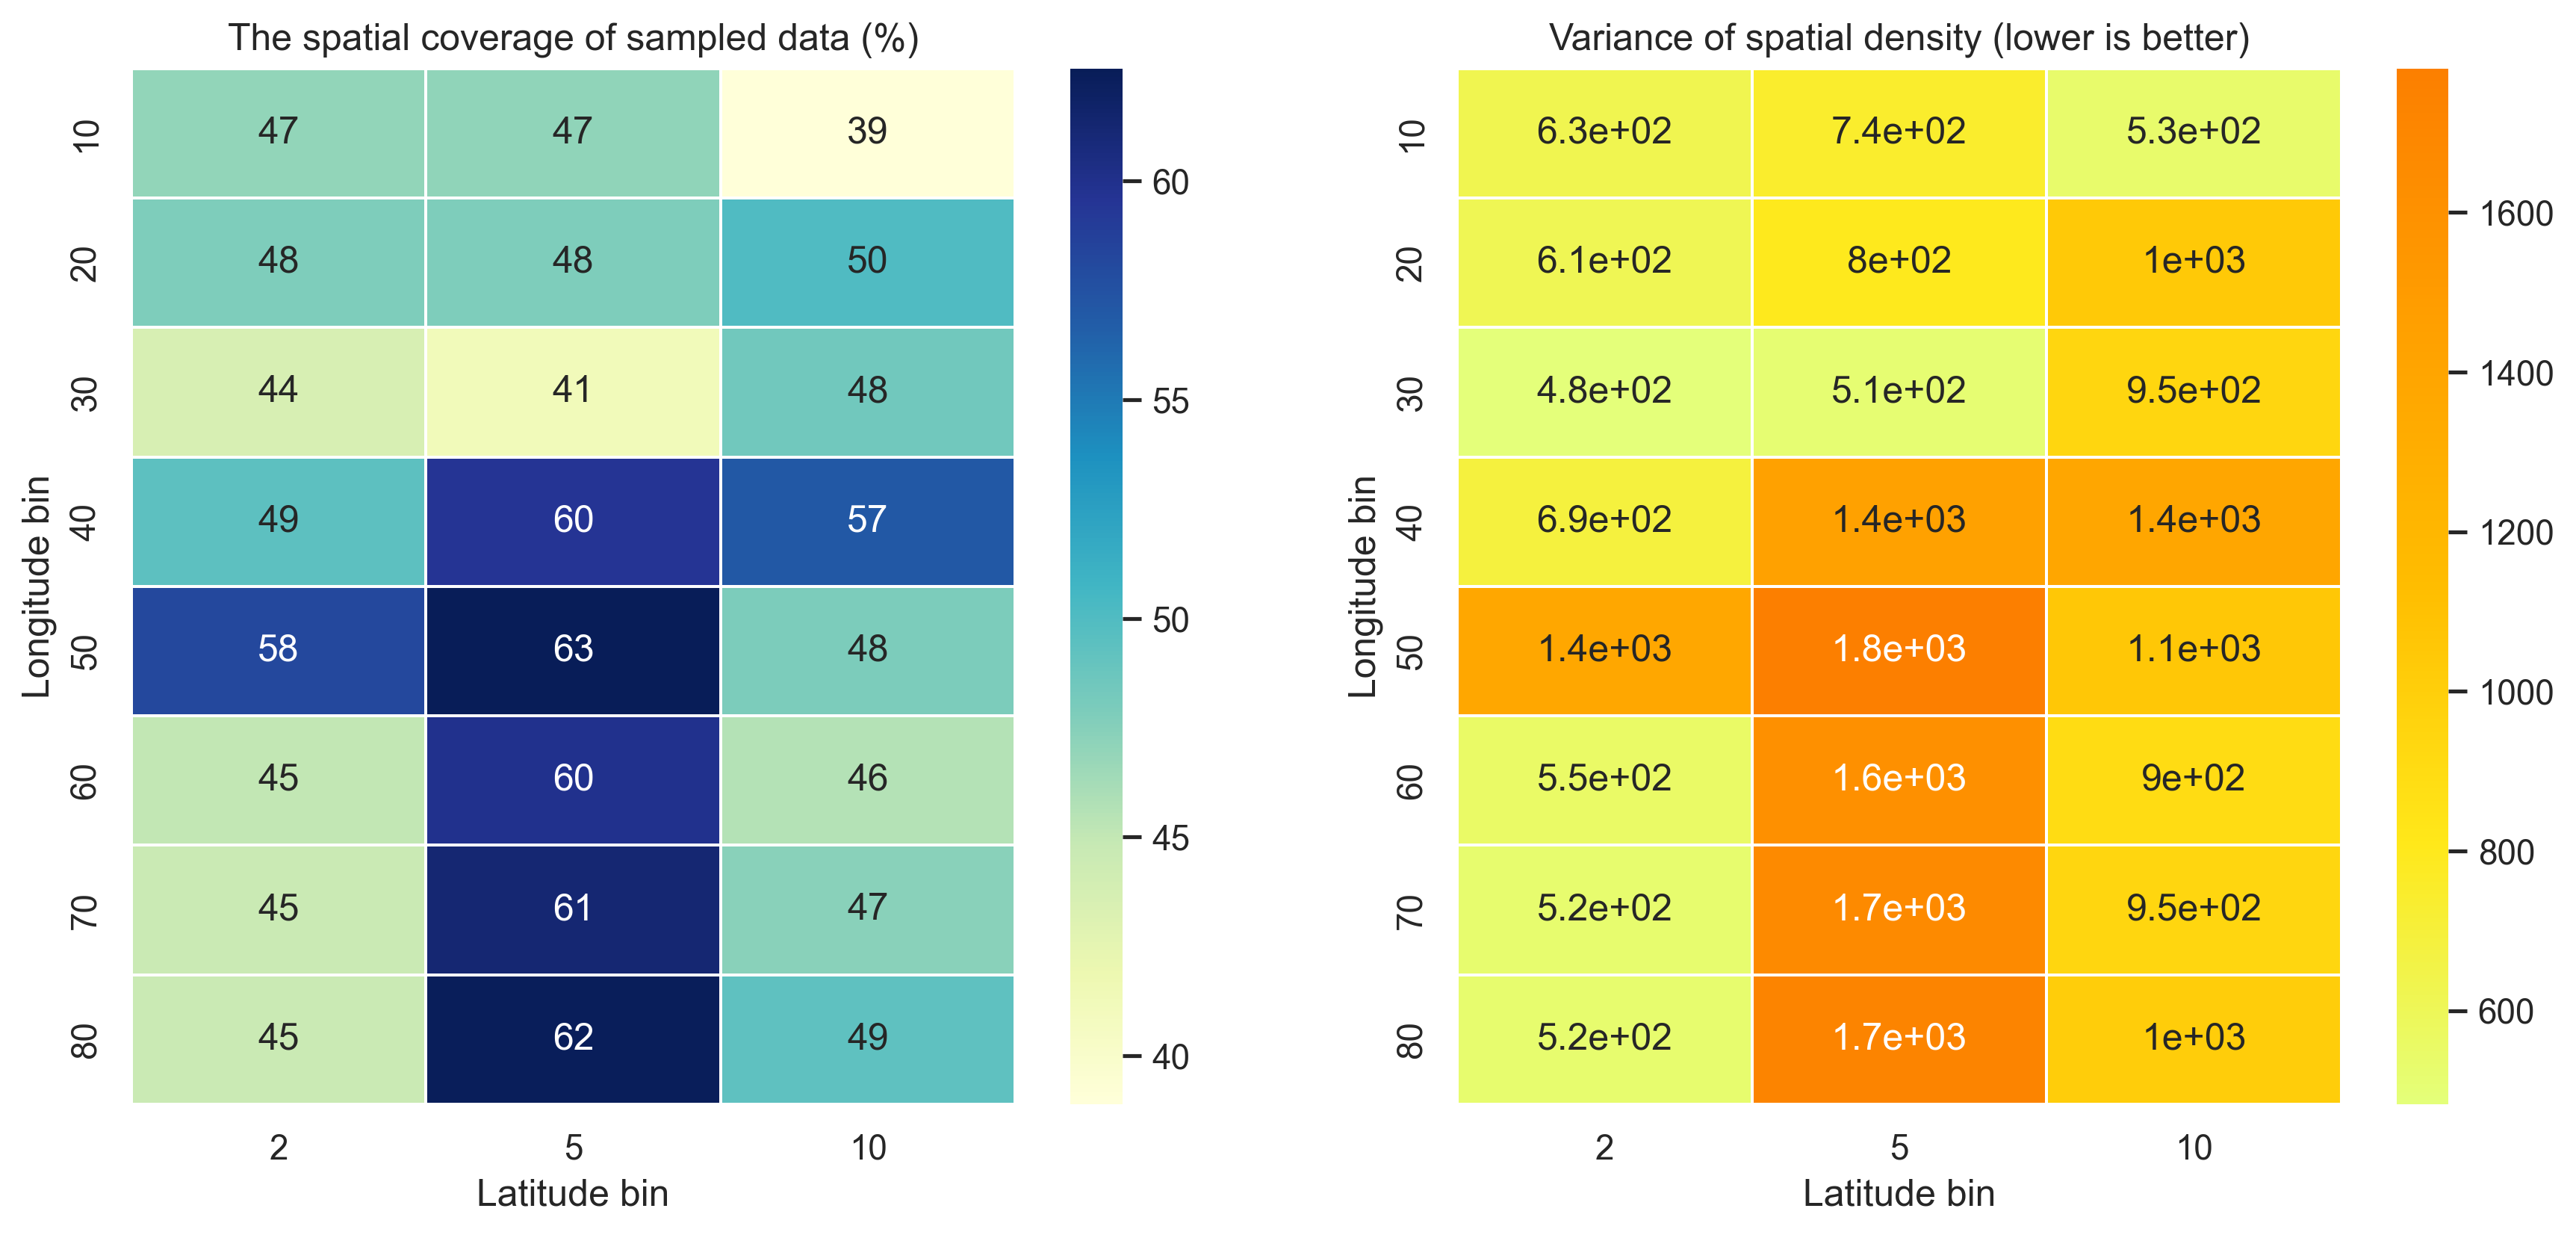

In [22]:
coverage_ana(ds_cleaned_250)

## An example of sampling the training data

In [4]:
ds_train_750_latlonT_5_60_95=prepare_training_data(5,60,0.95,ds_cleaned_750,1)

Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 1913
threshold=4807, training dataset size=22956


In [6]:
ds_train_750_latlonT_5_60_95

<xarray.Dataset>
Dimensions:           (nprof: 22956, pressure: 148)
Coordinates:
    profiler          (nprof) <U13 'itp123grd0288' ... 'itp10grd0227'
    date              (nprof) datetime64[ns] 2022-01-10T18:02:07.008000 ... 2...
    lon               (nprof) float64 -155.9 -158.1 -140.3 ... -138.4 -112.9
    lat               (nprof) float64 73.88 73.64 74.91 ... 88.65 80.06 83.89
  * pressure          (pressure) float64 -10.0 -15.0 -20.0 ... -740.0 -745.0
  * nprof             (nprof) int32 0 1 2 3 4 ... 22951 22952 22953 22954 22955
Data variables:
    temperature       (nprof, pressure) float64 -1.487 -1.486 ... 0.2294 0.2256
    salinity          (nprof, pressure) float64 27.58 27.58 27.6 ... 34.88 34.88
    dissolved_oxygen  (nprof, pressure) float64 nan nan nan nan ... nan nan nan
    lat_step          int32 5
    lon_step          int32 60
    quantile4T        float64 0.95

## The temporal and spatial distribution of the training data

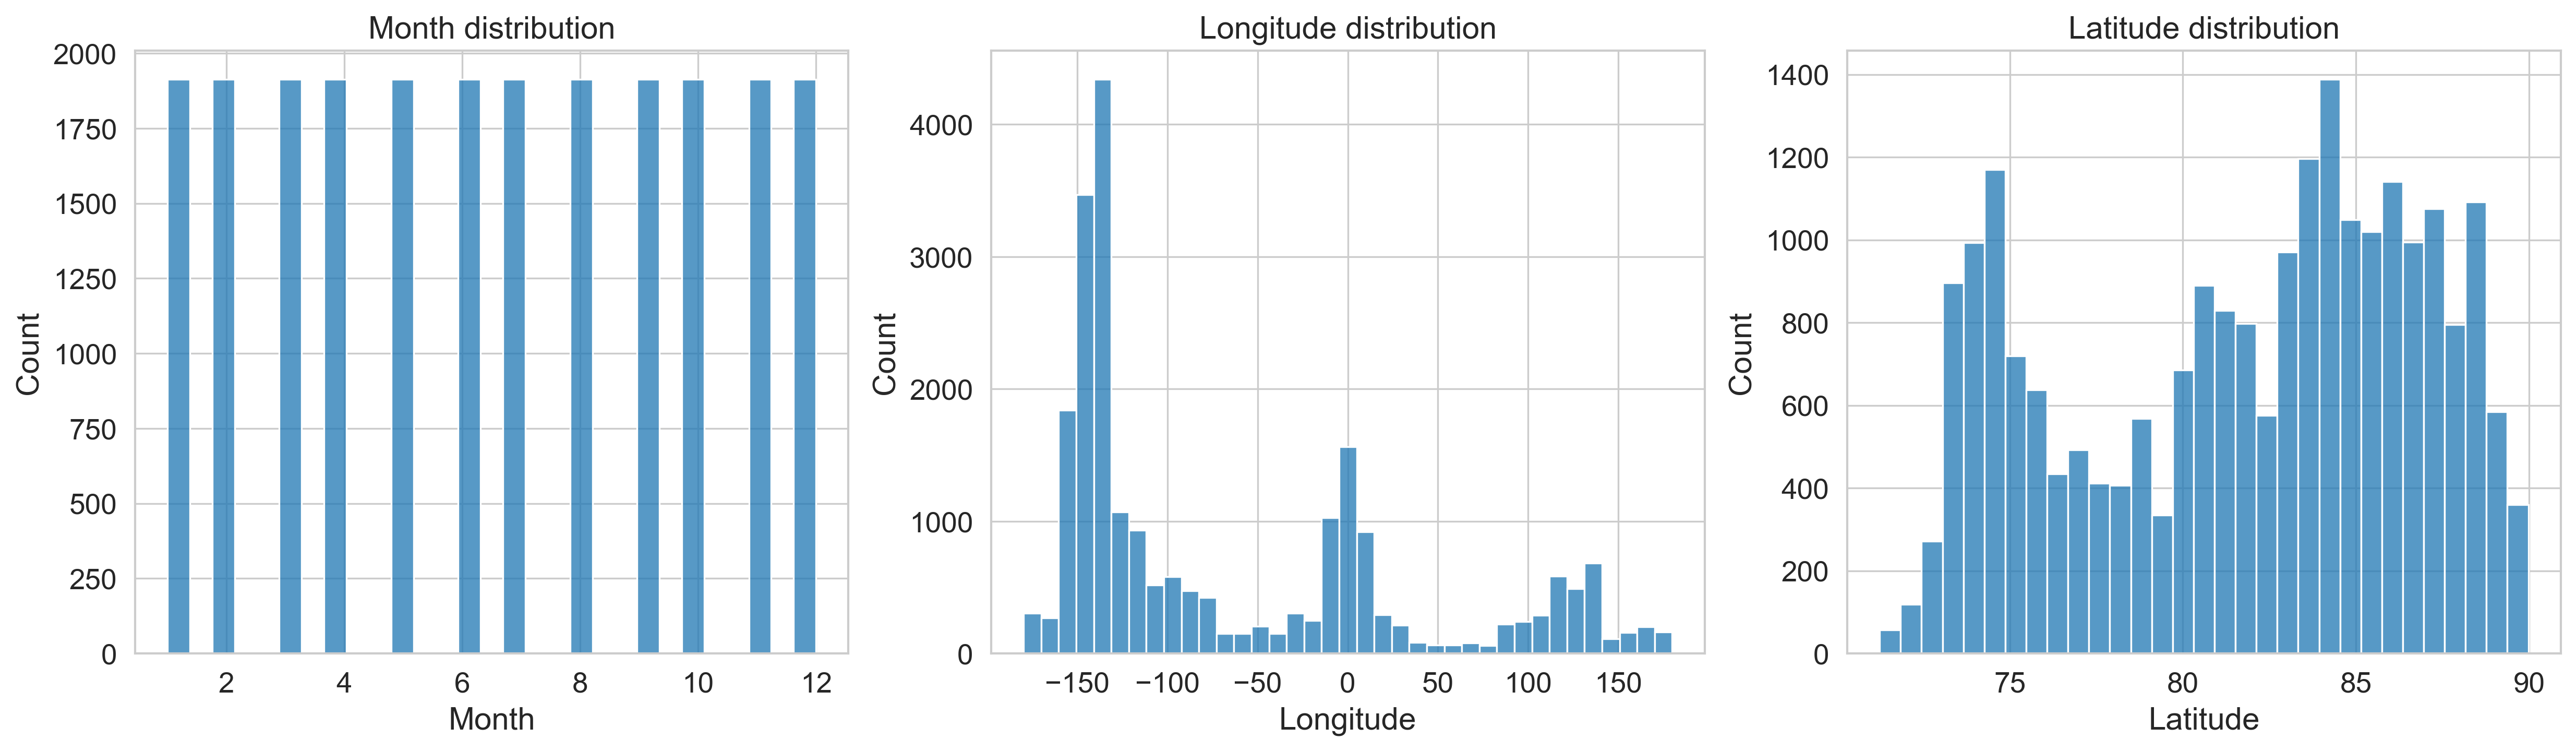

In [10]:
from toolbox import plot_basic_statistics as pbs
pbs.plot_month_latlon_dis(ds_train_750_latlonT_5_60_95)

## Compared to the original data

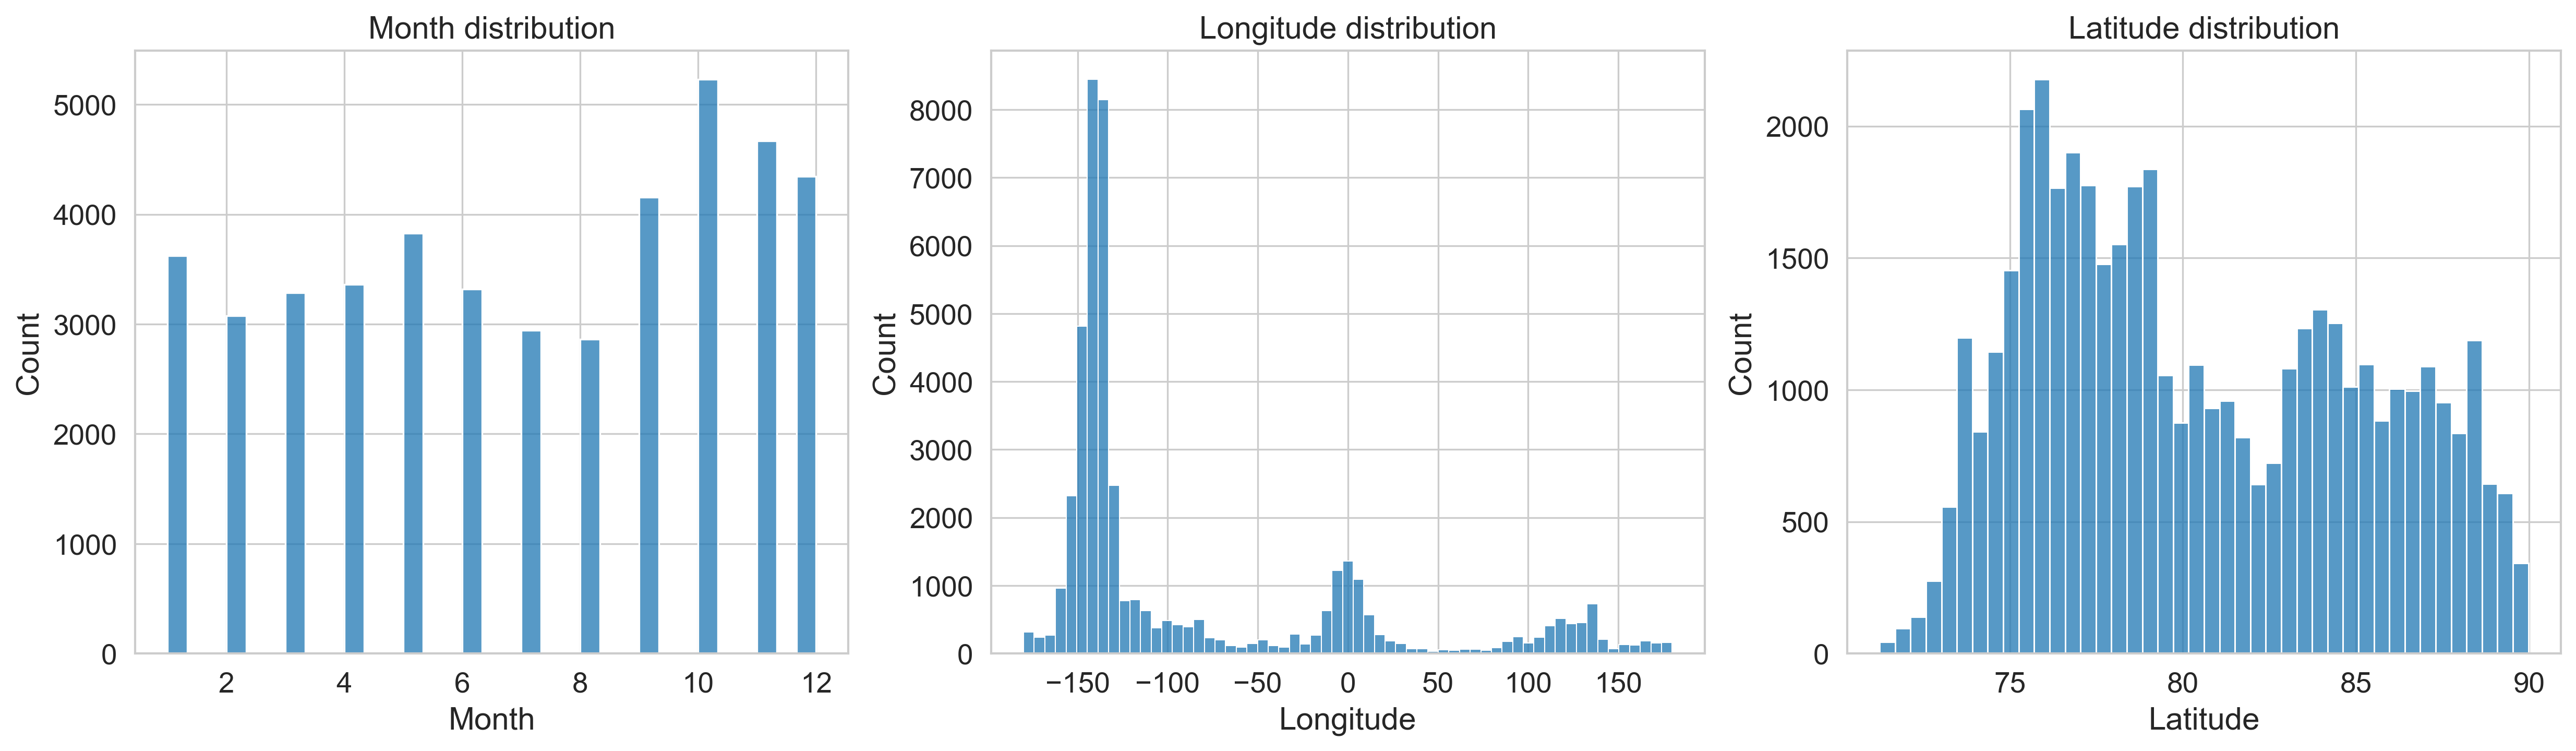

In [12]:
pbs.plot_month_latlon_dis(ds_cleaned_750)

## Generate the training data for 750 and 250 data

In [5]:
ds_train_750_latlonT_5_60_95=prepare_training_data(5,60,0.95,ds_cleaned_750,1)
ds_train_750_latlonT_5_50_95=prepare_training_data(5,50,0.95,ds_cleaned_750,1)
ds_train_750_latlonT_5_70_95=prepare_training_data(5,70,0.95,ds_cleaned_750,1)


ds_train_250_latlonT_10_20_95=prepare_training_data(10,20,0.95,ds_cleaned_250,1)
ds_train_250_latlonT_10_10_95=prepare_training_data(10,10,0.95,ds_cleaned_250,1)
ds_train_250_latlonT_10_30_95=prepare_training_data(10,30,0.95,ds_cleaned_250,1)

Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 1913
threshold=4807, training dataset size=22956
No data points for group (nan, Interval(75, 80, closed='right'))
No data points for group (nan, Interval(80, 85, closed='right'))
No data points for group (nan, Interval(85, 90, closed='right'))
No data points for group (nan, Interval(75, 80, closed='right'))
No data points for group (nan, Interval(80, 85, closed='right'))
No data points for group (nan, Interval(85, 90, closed='right'))
Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 1971
threshold=4770, training dataset size=23652
No data points for group (nan, Interval(75, 80, closed='right'))
No data points for group (nan, Interval(80, 85, closed='right'))
No data points for group (nan, Interval(85, 90, closed='right'))
No data points for group (nan, Interval(75, 80, closed='right'))
No data points for group (nan, Interval(80, 85, closed='right'))
No data points for group (nan

## Save the training data

In [6]:

import os
os.chdir(proj_path)
# create a folder to store the training data under the project folder if it does not exist
if not os.path.exists('training_data'):
    os.makedirs('training_data')

# save the data to /training_data
ds_train_750_latlonT_5_60_95.to_netcdf(f'{proj_path}/training_data/ds_train_750_latlonT_5_60_95.nc')
ds_train_750_latlonT_5_50_95.to_netcdf(f'{proj_path}/training_data/ds_train_750_latlonT_5_50_95.nc')
ds_train_750_latlonT_5_70_95.to_netcdf(f'{proj_path}/training_data/ds_train_750_latlonT_5_70_95.nc')

ds_train_250_latlonT_10_20_95.to_netcdf(f'{proj_path}/training_data/ds_train_250_latlonT_10_20_95.nc')
ds_train_250_latlonT_10_10_95.to_netcdf(f'{proj_path}/training_data/ds_train_250_latlonT_10_10_95.nc')
ds_train_250_latlonT_10_30_95.to_netcdf(f'{proj_path}/training_data/ds_train_250_latlonT_10_30_95.nc')